# 401K vs Roth 401K Analysis: High-Income Earner Study

## Comprehensive 60-Year Lifecycle Analysis

This notebook provides a detailed comparison between 401K pre-tax and Roth 401K strategies for a high-income earner making $550,000 annually. The analysis spans 60 years (ages 35-95) and uses dynamic tax calculations based on actual withdrawal amounts rather than assumptions.

### Key Features:
- **Dynamic Tax Calculation**: Real-time tax rate calculations based on withdrawal amounts
- **Equal Lifestyle Comparison**: Comparing strategies based on equal after-tax standard of living
- **Complete Lifecycle**: Full 60-year analysis from accumulation to retirement
- **Mixed Account Structure**: 401K strategy includes both pre-tax and taxable accounts

## Section 1: Import Required Libraries and Setup

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
import warnings

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configuration
np.random.seed(42)
print("Libraries imported successfully!")
print("Python environment ready for 401K vs Roth analysis")


Libraries imported successfully!
Python environment ready for 401K vs Roth analysis


## Section 2: Define Tax Calculation Functions

The tax functions below implement the progressive federal income tax system with proper marginal tax brackets. This is crucial for accurate analysis as tax rates vary significantly based on income levels.

In [12]:
# 2024 Federal Tax Brackets (Single Filer)
TAX_BRACKETS = [
    (0, 11000, 0.10),
    (11000, 44725, 0.12),
    (44725, 95375, 0.22),
    (95375, 182050, 0.24),
    (182050, 231250, 0.32),
    (231250, 578125, 0.35),
    (578125, float('inf'), 0.37)
]

STANDARD_DEDUCTION = 14600  # 2024 standard deduction for single filer

def calculate_federal_tax(income: float) -> float:
    """
    Calculate federal income tax using progressive tax brackets.
    
    Args:
        income: Gross income amount
        
    Returns:
        Total federal tax owed
    """
    if income <= STANDARD_DEDUCTION:
        return 0
    
    taxable_income = income - STANDARD_DEDUCTION
    total_tax = 0
    
    for lower, upper, rate in TAX_BRACKETS:
        if taxable_income <= lower:
            break
        
        taxable_in_bracket = min(taxable_income, upper) - lower
        total_tax += taxable_in_bracket * rate
        
        if taxable_income <= upper:
            break
    
    return total_tax

def calculate_effective_tax_rate(income: float) -> float:
    """
    Calculate the effective tax rate (total tax / total income).
    
    Args:
        income: Gross income amount
        
    Returns:
        Effective tax rate as a decimal
    """
    if income <= 0:
        return 0
    return calculate_federal_tax(income) / income

def calculate_marginal_tax_rate(income: float) -> float:
    """
    Calculate the marginal tax rate at a given income level.
    
    Args:
        income: Gross income amount
        
    Returns:
        Marginal tax rate as a decimal
    """
    if income <= STANDARD_DEDUCTION:
        return 0
    
    taxable_income = income - STANDARD_DEDUCTION
    
    for lower, upper, rate in TAX_BRACKETS:
        if lower <= taxable_income < upper:
            return rate
    
    return TAX_BRACKETS[-1][2]  # Highest bracket

# Test the tax functions
test_income = 550000
print(f"Test Income: ${test_income:,}")
print(f"Federal Tax: ${calculate_federal_tax(test_income):,.2f}")
print(f"Effective Rate: {calculate_effective_tax_rate(test_income):.2%}")
print(f"Marginal Rate: {calculate_marginal_tax_rate(test_income):.2%}")


Test Income: $550,000
Federal Tax: $159,288.50
Effective Rate: 28.96%
Marginal Rate: 35.00%


## Section 3: Set Investment Parameters and Contribution Limits

Here we define all the key assumptions for our analysis, including income levels, investment returns, and annual contribution limits with catch-up provisions.

In [13]:
# Core Investment Parameters
ANNUAL_INCOME = 550000
ACCUMULATION_RETURN = 0.07  # 7% during working years
RETIREMENT_RETURN = 0.05    # 5% during retirement
STARTING_AGE = 35
RETIREMENT_AGE = 65
FINAL_AGE = 95
ANALYSIS_YEARS = FINAL_AGE - STARTING_AGE

# 401k Contribution Limits (2024 values, assuming they grow with inflation)
def get_contribution_limit(age: int, year: int) -> Dict[str, float]:
    """
    Get 401k contribution limits based on age and year.
    Includes catch-up contributions for those 50+.
    """
    base_year = 2024
    inflation_factor = (1.025) ** (year - base_year)  # Assume 2.5% annual growth
    
    base_limit = 23000 * inflation_factor
    catchup_limit = 7500 * inflation_factor if age >= 50 else 0
    
    return {
        'base': base_limit,
        'catchup': catchup_limit,
        'total': base_limit + catchup_limit
    }

# Create contribution limits table
contribution_data = []
for year in range(ANALYSIS_YEARS + 1):
    age = STARTING_AGE + year
    calendar_year = 2024 + year
    limits = get_contribution_limit(age, calendar_year)
    
    contribution_data.append({
        'Year': year,
        'Age': age,
        'Calendar_Year': calendar_year,
        'Base_Limit': limits['base'],
        'Catchup_Limit': limits['catchup'],
        'Total_Limit': limits['total']
    })

contribution_df = pd.DataFrame(contribution_data)

print("Investment Parameters:")
print(f"Annual Income: ${ANNUAL_INCOME:,}")
print(f"Accumulation Return: {ACCUMULATION_RETURN:.1%}")
print(f"Retirement Return: {RETIREMENT_RETURN:.1%}")
print(f"Analysis Period: {ANALYSIS_YEARS} years (ages {STARTING_AGE}-{FINAL_AGE})")
print("\nSample Contribution Limits:")
print(contribution_df[contribution_df['Age'].isin([35, 50, 65])].to_string(index=False))


Investment Parameters:
Annual Income: $550,000
Accumulation Return: 7.0%
Retirement Return: 5.0%
Analysis Period: 60 years (ages 35-95)

Sample Contribution Limits:
 Year  Age  Calendar_Year   Base_Limit  Catchup_Limit  Total_Limit
    0   35           2024 23000.000000       0.000000 23000.000000
   15   50           2039 33310.857829   10862.236249 44173.094078
   30   65           2054 48244.054319   15731.756843 63975.811162


## Section 4: Calculate Annual Contributions for Both Strategies

This section calculates the maximum allowable contributions for both strategies and determines how tax savings from 401K contributions are invested in taxable accounts.

In [14]:
def calculate_contribution_strategy(contribution_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate annual contributions and tax impacts for both 401K and Roth strategies.
    
    Returns:
        DataFrame with contribution details for both strategies
    """
    strategy_data = []
    
    for _, row in contribution_df.iterrows():
        year = int(row['Year'])
        age = int(row['Age'])
        max_contribution = row['Total_Limit']
        
        # Both strategies contribute the same dollar amount to retirement accounts
        contribution_401k = max_contribution
        contribution_roth = max_contribution
        
        # Calculate tax savings from 401K (reduces current year taxes)
        current_marginal_rate = calculate_marginal_tax_rate(ANNUAL_INCOME)
        tax_savings_401k = contribution_401k * current_marginal_rate
        
        # For 401K strategy: tax savings are invested in taxable account
        # For Roth strategy: no tax savings, but contribution is after-tax
        
        # Calculate after-tax cost of each strategy
        after_tax_cost_401k = contribution_401k - tax_savings_401k  # Net cost after tax savings
        after_tax_cost_roth = contribution_roth  # Full amount (already after-tax)
        
        # Taxable investment for 401K strategy (from tax savings)
        taxable_investment_401k = tax_savings_401k
        taxable_investment_roth = 0  # Roth has no tax savings to invest
        
        strategy_data.append({
            'Year': year,
            'Age': age,
            'Max_Contribution': max_contribution,
            '401K_Contribution': contribution_401k,
            'Roth_Contribution': contribution_roth,
            'Tax_Savings_401K': tax_savings_401k,
            'After_Tax_Cost_401K': after_tax_cost_401k,
            'After_Tax_Cost_Roth': after_tax_cost_roth,
            'Taxable_Investment_401K': taxable_investment_401k,
            'Taxable_Investment_Roth': taxable_investment_roth,
            'Marginal_Tax_Rate': current_marginal_rate
        })
    
    return pd.DataFrame(strategy_data)

# Calculate contribution strategies for accumulation years only
accumulation_years = contribution_df[contribution_df['Age'] < RETIREMENT_AGE].copy()
strategy_df = calculate_contribution_strategy(accumulation_years)

print("Contribution Strategy Comparison (Sample Years):")
print("\nWorking Years (35-64):")
sample_years = strategy_df[strategy_df['Age'].isin([35, 45, 55, 64])]
display_cols = ['Age', '401K_Contribution', 'Roth_Contribution', 'Tax_Savings_401K', 
                'Taxable_Investment_401K', 'Marginal_Tax_Rate']
print(sample_years[display_cols].to_string(index=False))

print("\nTotal 30-Year Contributions:")
print(f"401K Retirement Account: ${strategy_df['401K_Contribution'].sum():,.0f}")
print(f"Roth Retirement Account: ${strategy_df['Roth_Contribution'].sum():,.0f}")
print(f"401K Taxable Investments: ${strategy_df['Taxable_Investment_401K'].sum():,.0f}")
print(f"Total Tax Savings (401K): ${strategy_df['Tax_Savings_401K'].sum():,.0f}")


Contribution Strategy Comparison (Sample Years):

Working Years (35-64):
 Age  401K_Contribution  Roth_Contribution  Tax_Savings_401K  Taxable_Investment_401K  Marginal_Tax_Rate
  35       23000.000000       23000.000000       8050.000000              8050.000000               0.35
  45       29441.944517       29441.944517      10304.680581             10304.680581               0.35
  55       49977.801429       49977.801429      17492.230500             17492.230500               0.35
  64       62415.425524       62415.425524      21845.398933             21845.398933               0.35

Total 30-Year Contributions:
401K Retirement Account: $1,204,543
Roth Retirement Account: $1,204,543
401K Taxable Investments: $421,590
Total Tax Savings (401K): $421,590


## Section 5: Model Accumulation Phase (Ages 35-65)

This section simulates the 30-year accumulation period, tracking account balances with compound growth for both strategies.

In [15]:
def model_accumulation_phase(strategy_df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Model the accumulation phase for both 401K and Roth strategies.
    
    Returns:
        Dictionary containing DataFrames for both strategies
    """
    
    # Initialize tracking variables
    accumulation_401k = []
    accumulation_roth = []
    
    # Starting balances
    balance_401k = 0
    balance_roth = 0
    balance_taxable_401k = 0
    
    # Process each year
    for _, row in strategy_df.iterrows():
        year = int(row['Year'])
        age = int(row['Age'])
        
        # 401K Strategy
        # Add this year's contribution
        balance_401k += row['401K_Contribution']
        balance_taxable_401k += row['Taxable_Investment_401K']
        
        # Apply investment growth
        balance_401k *= (1 + ACCUMULATION_RETURN)
        balance_taxable_401k *= (1 + ACCUMULATION_RETURN)
        
        # Calculate taxes on taxable account gains
        taxable_gains = balance_taxable_401k * ACCUMULATION_RETURN / (1 + ACCUMULATION_RETURN)
        taxable_taxes = taxable_gains * 0.15  # Assume 15% capital gains rate
        balance_taxable_401k -= taxable_taxes
        
        accumulation_401k.append({
            'Year': year,
            'Age': age,
            'Annual_Contribution': row['401K_Contribution'],
            'Retirement_Balance': balance_401k,
            'Taxable_Balance': balance_taxable_401k,
            'Total_Balance': balance_401k + balance_taxable_401k,
            'Taxable_Taxes_Paid': taxable_taxes
        })
        
        # Roth Strategy
        # Add this year's contribution
        balance_roth += row['Roth_Contribution']
        
        # Apply investment growth (no taxes during accumulation)
        balance_roth *= (1 + ACCUMULATION_RETURN)
        
        accumulation_roth.append({
            'Year': year,
            'Age': age,
            'Annual_Contribution': row['Roth_Contribution'],
            'Retirement_Balance': balance_roth,
            'Taxable_Balance': 0,
            'Total_Balance': balance_roth,
            'Taxable_Taxes_Paid': 0
        })
    
    return {
        '401K': pd.DataFrame(accumulation_401k),
        'Roth': pd.DataFrame(accumulation_roth)
    }

# Model the accumulation phase
accumulation_results = model_accumulation_phase(strategy_df)

print("Accumulation Phase Results (Sample Years):")
print("\n401K Strategy:")
sample_401k = accumulation_results['401K'][accumulation_results['401K']['Age'].isin([35, 45, 55, 64])]
print(sample_401k[['Age', 'Annual_Contribution', 'Retirement_Balance', 'Taxable_Balance', 'Total_Balance']].to_string(index=False))

print("\nRoth Strategy:")
sample_roth = accumulation_results['Roth'][accumulation_results['Roth']['Age'].isin([35, 45, 55, 64])]
print(sample_roth[['Age', 'Annual_Contribution', 'Retirement_Balance', 'Total_Balance']].to_string(index=False))

print(f"\nFinal Balances at Age {RETIREMENT_AGE}:")
final_401k = accumulation_results['401K'].iloc[-1]
final_roth = accumulation_results['Roth'].iloc[-1]

print("401K Strategy:")
print(f"  Retirement Account: ${final_401k['Retirement_Balance']:,.0f}")
print(f"  Taxable Account: ${final_401k['Taxable_Balance']:,.0f}")
print(f"  Total: ${final_401k['Total_Balance']:,.0f}")

print("Roth Strategy:")
print(f"  Retirement Account: ${final_roth['Retirement_Balance']:,.0f}")
print(f"  Total: ${final_roth['Total_Balance']:,.0f}")


Accumulation Phase Results (Sample Years):

401K Strategy:
 Age  Annual_Contribution  Retirement_Balance  Taxable_Balance  Total_Balance
  35         23000.000000        2.461000e+04      8528.975000   3.313897e+04
  45         29441.944517        4.335545e+05    142492.086128   5.760466e+05
  55         49977.801429        1.433966e+06    446672.883366   1.880639e+06
  64         62415.425524        3.354457e+06    990116.412967   4.344574e+06

Roth Strategy:
 Age  Annual_Contribution  Retirement_Balance  Total_Balance
  35         23000.000000        2.461000e+04   2.461000e+04
  45         29441.944517        4.335545e+05   4.335545e+05
  55         49977.801429        1.433966e+06   1.433966e+06
  64         62415.425524        3.354457e+06   3.354457e+06

Final Balances at Age 65:
401K Strategy:
  Retirement Account: $3,354,457
  Taxable Account: $990,116
  Total: $4,344,574
Roth Strategy:
  Retirement Account: $3,354,457
  Total: $3,354,457


## Section 6: Calculate Retirement Tax Rates and Withdrawal Strategies

This section determines optimal withdrawal amounts and calculates actual tax rates based on withdrawal needs, ensuring equal after-tax lifestyle standards.

In [16]:
def calculate_annual_withdrawal_need(starting_balance: float, years: int, return_rate: float) -> float:
    """
    Calculate the annual withdrawal amount needed to deplete balance to $0 over specified years.
    Uses the annuity payment formula: PMT = PV * (r * (1+r)^n) / ((1+r)^n - 1)
    
    Args:
        starting_balance: Initial account balance
        years: Number of years to deplete the account
        return_rate: Annual investment return rate
        
    Returns:
        Annual withdrawal amount
    """
    if return_rate == 0:
        return starting_balance / years
    
    # Annuity payment formula
    factor = (return_rate * (1 + return_rate) ** years) / ((1 + return_rate) ** years - 1)
    return starting_balance * factor

def optimize_withdrawal_strategy(balance_401k: float, balance_taxable: float, balance_roth: float, 
                               retirement_years: int) -> Dict[str, float]:
    """
    Optimize withdrawal strategy to maximize after-tax income.
    
    For equal lifestyle comparison, we need to determine what withdrawal amounts
    from each strategy would provide the same after-tax spending power.
    
    Args:
        balance_401k: 401K retirement account balance
        balance_taxable: Taxable investment account balance
        balance_roth: Roth account balance
        retirement_years: Number of retirement years
        
    Returns:
        Dictionary with optimal withdrawal amounts and strategies
    """
    
    # Strategy 1: 401K + Taxable (mixed withdrawal strategy)
    # First, calculate total available for 401K strategy
    total_401k_strategy = balance_401k + balance_taxable
    
    # Strategy 2: Roth (tax-free withdrawals)
    total_roth_strategy = balance_roth
    
    # Calculate raw withdrawal amounts (before taxes)
    withdrawal_401k_strategy = calculate_annual_withdrawal_need(
        total_401k_strategy, retirement_years, RETIREMENT_RETURN
    )
    withdrawal_roth_strategy = calculate_annual_withdrawal_need(
        total_roth_strategy, retirement_years, RETIREMENT_RETURN
    )
    
    # For 401K strategy, we need to optimize the mix between 401K (taxable) and taxable (cap gains)
    # Assume we withdraw proportionally from both accounts
    prop_401k = balance_401k / total_401k_strategy
    prop_taxable = balance_taxable / total_401k_strategy
    
    annual_401k_withdrawal = withdrawal_401k_strategy * prop_401k
    annual_taxable_withdrawal = withdrawal_401k_strategy * prop_taxable
    
    # Calculate taxes on 401K withdrawals (ordinary income)
    tax_on_401k_withdrawal = calculate_federal_tax(annual_401k_withdrawal)
    
    # Calculate taxes on taxable withdrawals (assume 50% is gains, 15% cap gains rate)
    taxable_gains = annual_taxable_withdrawal * 0.5  # Assume 50% of withdrawal is gains
    tax_on_taxable_withdrawal = taxable_gains * 0.15  # 15% capital gains rate
    
    total_taxes_401k_strategy = tax_on_401k_withdrawal + tax_on_taxable_withdrawal
    after_tax_income_401k = withdrawal_401k_strategy - total_taxes_401k_strategy
    
    # Roth withdrawals are tax-free
    after_tax_income_roth = withdrawal_roth_strategy
    
    return {
        'total_401k_balance': total_401k_strategy,
        'total_roth_balance': total_roth_strategy,
        'annual_withdrawal_401k_strategy': withdrawal_401k_strategy,
        'annual_withdrawal_roth_strategy': withdrawal_roth_strategy,
        'annual_401k_account_withdrawal': annual_401k_withdrawal,
        'annual_taxable_account_withdrawal': annual_taxable_withdrawal,
        'taxes_401k_strategy': total_taxes_401k_strategy,
        'taxes_roth_strategy': 0,
        'after_tax_income_401k': after_tax_income_401k,
        'after_tax_income_roth': after_tax_income_roth,
        'effective_tax_rate_401k': total_taxes_401k_strategy / withdrawal_401k_strategy if withdrawal_401k_strategy > 0 else 0,
        'effective_tax_rate_roth': 0
    }

# Calculate optimal withdrawal strategies
final_401k = accumulation_results['401K'].iloc[-1]
final_roth = accumulation_results['Roth'].iloc[-1]

retirement_years = FINAL_AGE - RETIREMENT_AGE
withdrawal_analysis = optimize_withdrawal_strategy(
    final_401k['Retirement_Balance'],
    final_401k['Taxable_Balance'], 
    final_roth['Retirement_Balance'],
    retirement_years
)

print("Retirement Withdrawal Strategy Analysis:")
print(f"Retirement Period: {retirement_years} years (ages {RETIREMENT_AGE}-{FINAL_AGE})")
print(f"Investment Return During Retirement: {RETIREMENT_RETURN:.1%}")

print("\n401K Strategy:")
print(f"  Total Available: ${withdrawal_analysis['total_401k_balance']:,.0f}")
print(f"  Annual Gross Withdrawal: ${withdrawal_analysis['annual_withdrawal_401k_strategy']:,.0f}")
print(f"    From 401K Account: ${withdrawal_analysis['annual_401k_account_withdrawal']:,.0f}")
print(f"    From Taxable Account: ${withdrawal_analysis['annual_taxable_account_withdrawal']:,.0f}")
print(f"  Annual Taxes: ${withdrawal_analysis['taxes_401k_strategy']:,.0f}")
print(f"  Annual After-Tax Income: ${withdrawal_analysis['after_tax_income_401k']:,.0f}")
print(f"  Effective Tax Rate: {withdrawal_analysis['effective_tax_rate_401k']:.2%}")

print("\nRoth Strategy:")
print(f"  Total Available: ${withdrawal_analysis['total_roth_balance']:,.0f}")
print(f"  Annual Gross Withdrawal: ${withdrawal_analysis['annual_withdrawal_roth_strategy']:,.0f}")
print(f"  Annual Taxes: ${withdrawal_analysis['taxes_roth_strategy']:,.0f}")
print(f"  Annual After-Tax Income: ${withdrawal_analysis['after_tax_income_roth']:,.0f}")
print(f"  Effective Tax Rate: {withdrawal_analysis['effective_tax_rate_roth']:.2%}")


Retirement Withdrawal Strategy Analysis:
Retirement Period: 30 years (ages 65-95)
Investment Return During Retirement: 5.0%

401K Strategy:
  Total Available: $4,344,574
  Annual Gross Withdrawal: $282,621
    From 401K Account: $218,212
    From Taxable Account: $64,408
  Annual Taxes: $48,823
  Annual After-Tax Income: $233,798
  Effective Tax Rate: 17.27%

Roth Strategy:
  Total Available: $3,354,457
  Annual Gross Withdrawal: $218,212
  Annual Taxes: $0
  Annual After-Tax Income: $218,212
  Effective Tax Rate: 0.00%


## Section 7: Model Distribution Phase (Ages 65-95)

This section simulates the 30-year retirement period with withdrawals from different account types, tracking remaining balances and ensuring both strategies deplete to $0 at age 95.

In [17]:
def model_distribution_phase(withdrawal_analysis: Dict[str, float], 
                           starting_401k: float, starting_taxable: float, starting_roth: float) -> Dict[str, pd.DataFrame]:
    """
    Model the distribution phase for both strategies.
    
    Args:
        withdrawal_analysis: Results from withdrawal optimization
        starting_401k: Starting 401K balance
        starting_taxable: Starting taxable balance  
        starting_roth: Starting Roth balance
        
    Returns:
        Dictionary containing distribution DataFrames for both strategies
    """
    
    distribution_401k = []
    distribution_roth = []
    
    # Initialize balances
    balance_401k = starting_401k
    balance_taxable = starting_taxable
    balance_roth = starting_roth
    
    # Annual withdrawal amounts
    annual_401k_withdrawal = withdrawal_analysis['annual_401k_account_withdrawal']
    annual_taxable_withdrawal = withdrawal_analysis['annual_taxable_account_withdrawal']
    annual_roth_withdrawal = withdrawal_analysis['annual_withdrawal_roth_strategy']
    
    for year in range(retirement_years):
        age = RETIREMENT_AGE + year
        
        # 401K Strategy Distribution
        # Apply investment growth first
        balance_401k *= (1 + RETIREMENT_RETURN)
        balance_taxable *= (1 + RETIREMENT_RETURN)
        
        # Make withdrawals
        balance_401k -= annual_401k_withdrawal
        balance_taxable -= annual_taxable_withdrawal
        
        # Calculate taxes
        tax_401k = calculate_federal_tax(annual_401k_withdrawal)
        tax_taxable = annual_taxable_withdrawal * 0.5 * 0.15  # 50% gains, 15% rate
        total_tax = tax_401k + tax_taxable
        
        gross_withdrawal = annual_401k_withdrawal + annual_taxable_withdrawal
        net_withdrawal = gross_withdrawal - total_tax
        
        distribution_401k.append({
            'Year': year,
            'Age': age,
            'Balance_401K': max(0, balance_401k),
            'Balance_Taxable': max(0, balance_taxable),
            'Total_Balance': max(0, balance_401k) + max(0, balance_taxable),
            'Gross_Withdrawal': gross_withdrawal,
            'Taxes_Paid': total_tax,
            'Net_Withdrawal': net_withdrawal,
            'Effective_Tax_Rate': total_tax / gross_withdrawal if gross_withdrawal > 0 else 0
        })
        
        # Roth Strategy Distribution  
        # Apply investment growth first
        balance_roth *= (1 + RETIREMENT_RETURN)
        
        # Make withdrawal (tax-free)
        balance_roth -= annual_roth_withdrawal
        
        distribution_roth.append({
            'Year': year,
            'Age': age,
            'Balance_Roth': max(0, balance_roth),
            'Total_Balance': max(0, balance_roth),
            'Gross_Withdrawal': annual_roth_withdrawal,
            'Taxes_Paid': 0,
            'Net_Withdrawal': annual_roth_withdrawal,
            'Effective_Tax_Rate': 0
        })
    
    return {
        '401K': pd.DataFrame(distribution_401k),
        'Roth': pd.DataFrame(distribution_roth)
    }

# Model the distribution phase
distribution_results = model_distribution_phase(
    withdrawal_analysis,
    final_401k['Retirement_Balance'],
    final_401k['Taxable_Balance'],
    final_roth['Retirement_Balance']
)

print("Distribution Phase Results (Sample Years):")
print("\n401K Strategy:")
sample_dist_401k = distribution_results['401K'][distribution_results['401K']['Age'].isin([65, 75, 85, 94])]
print(sample_dist_401k[['Age', 'Balance_401K', 'Balance_Taxable', 'Total_Balance', 
                        'Gross_Withdrawal', 'Taxes_Paid', 'Net_Withdrawal']].to_string(index=False))

print("\nRoth Strategy:")
sample_dist_roth = distribution_results['Roth'][distribution_results['Roth']['Age'].isin([65, 75, 85, 94])]
print(sample_dist_roth[['Age', 'Balance_Roth', 'Total_Balance', 
                        'Gross_Withdrawal', 'Net_Withdrawal']].to_string(index=False))

# Check final balances (should be close to 0)
final_dist_401k = distribution_results['401K'].iloc[-1]
final_dist_roth = distribution_results['Roth'].iloc[-1]

print(f"\nFinal Balances at Age {FINAL_AGE}:")
print(f"401K Strategy: ${final_dist_401k['Total_Balance']:,.0f}")
print(f"Roth Strategy: ${final_dist_roth['Total_Balance']:,.0f}")

print("\nLifetime Tax Comparison:")
total_taxes_401k = distribution_results['401K']['Taxes_Paid'].sum()
total_taxes_roth = distribution_results['Roth']['Taxes_Paid'].sum()
print(f"401K Strategy Total Taxes: ${total_taxes_401k:,.0f}")
print(f"Roth Strategy Total Taxes: ${total_taxes_roth:,.0f}")
print(f"Tax Difference: ${total_taxes_401k - total_taxes_roth:,.0f}")


Distribution Phase Results (Sample Years):

401K Strategy:
 Age  Balance_401K  Balance_Taxable  Total_Balance  Gross_Withdrawal   Taxes_Paid  Net_Withdrawal
  65  3.303968e+06     9.752137e+05   4.279182e+06     282620.755185 48822.560737   233798.194448
  75  2.637165e+06     7.783973e+05   3.415563e+06     282620.755185 48822.560737   233798.194448
  85  1.551014e+06     4.578041e+05   2.008818e+06     282620.755185 48822.560737   233798.194448
  94  8.905772e-09     4.612957e-09   1.351873e-08     282620.755185 48822.560737   233798.194448

Roth Strategy:
 Age  Balance_Roth  Total_Balance  Gross_Withdrawal  Net_Withdrawal
  65  3.303968e+06   3.303968e+06     218212.261625   218212.261625
  75  2.637165e+06   2.637165e+06     218212.261625   218212.261625
  85  1.551014e+06   1.551014e+06     218212.261625   218212.261625
  94  8.905772e-09   8.905772e-09     218212.261625   218212.261625

Final Balances at Age 95:
401K Strategy: $0
Roth Strategy: $0

Lifetime Tax Comparison:
401K S

## Section 8: Compare Final Results and Visualizations

This final section creates comprehensive comparisons including charts showing account balances over time, annual after-tax income, and total lifetime value analysis for both strategies.

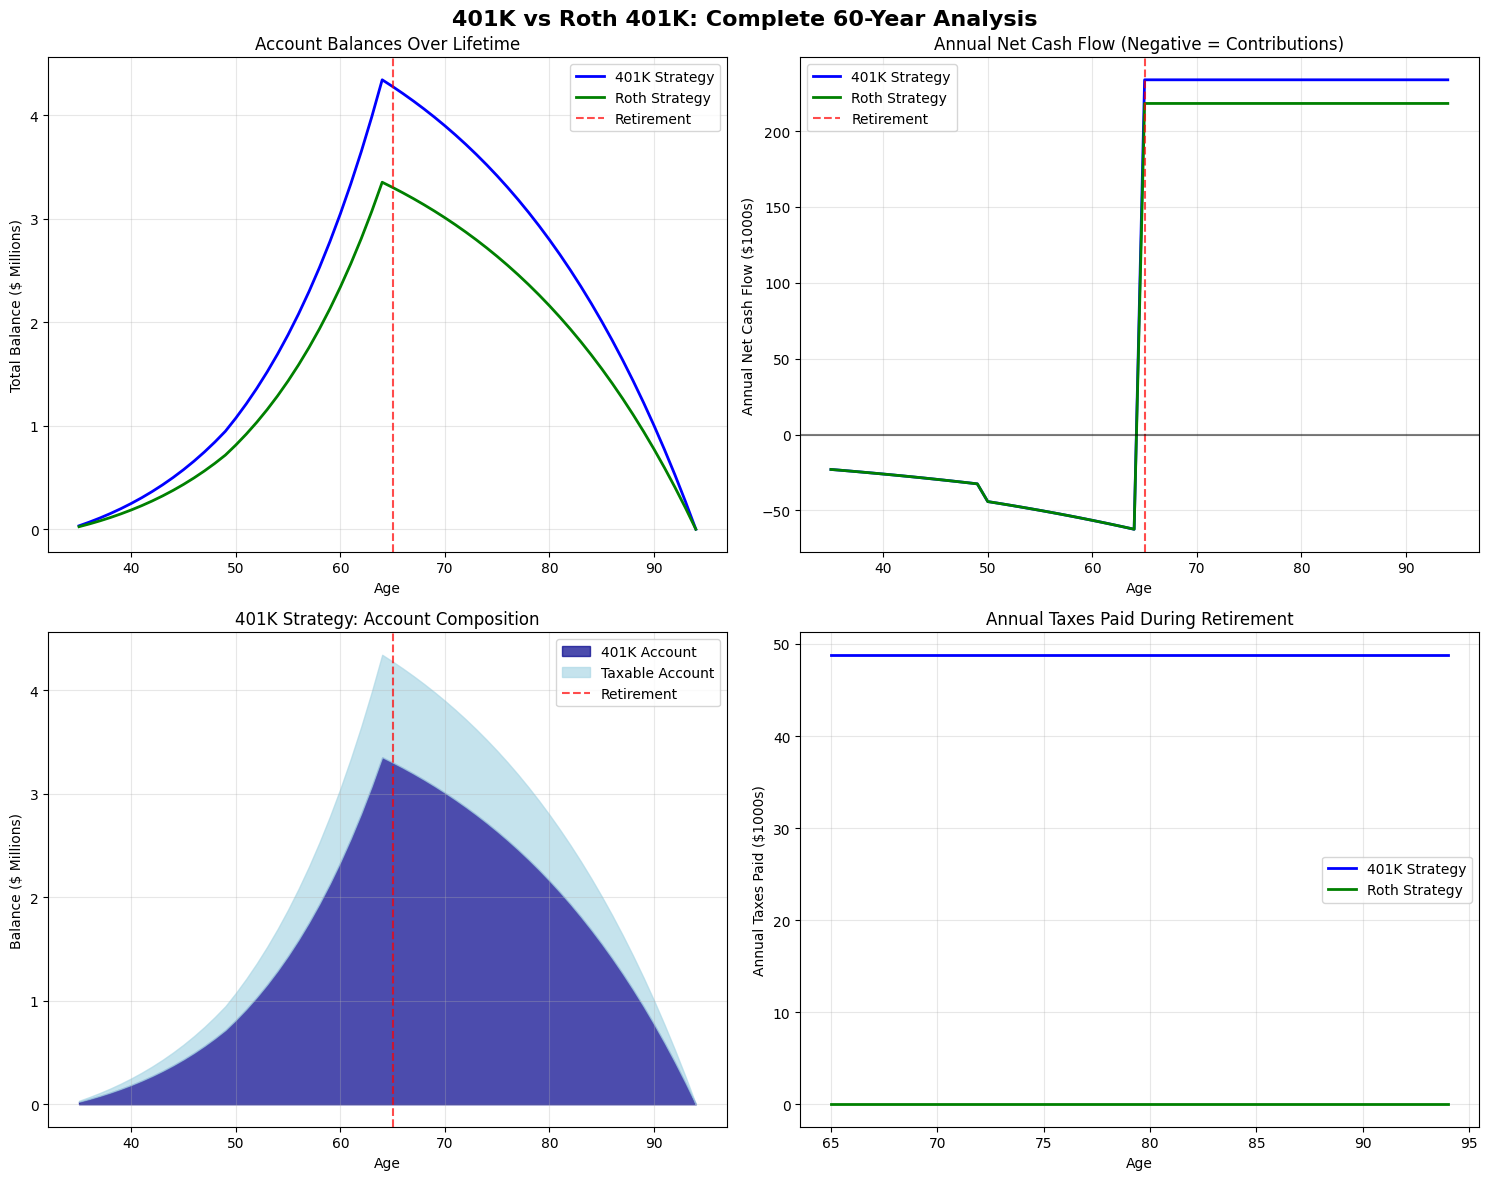

In [18]:
# Combine accumulation and distribution data for complete lifecycle view
def create_complete_lifecycle_data():
    """Combine accumulation and distribution phases into complete lifecycle view."""
    
    # 401K Strategy
    lifecycle_401k = []
    
    # Accumulation phase
    for _, row in accumulation_results['401K'].iterrows():
        lifecycle_401k.append({
            'Age': row['Age'],
            'Phase': 'Accumulation',
            'Retirement_Balance': row['Retirement_Balance'],
            'Taxable_Balance': row['Taxable_Balance'],
            'Total_Balance': row['Total_Balance'],
            'Annual_Contribution': row['Annual_Contribution'],
            'Annual_Withdrawal': 0,
            'Annual_Taxes': row.get('Taxable_Taxes_Paid', 0),
            'Net_Cash_Flow': -row['Annual_Contribution']
        })
    
    # Distribution phase
    for _, row in distribution_results['401K'].iterrows():
        lifecycle_401k.append({
            'Age': row['Age'],
            'Phase': 'Distribution',
            'Retirement_Balance': row.get('Balance_401K', 0),
            'Taxable_Balance': row.get('Balance_Taxable', 0),
            'Total_Balance': row['Total_Balance'],
            'Annual_Contribution': 0,
            'Annual_Withdrawal': row['Gross_Withdrawal'],
            'Annual_Taxes': row['Taxes_Paid'],
            'Net_Cash_Flow': row['Net_Withdrawal']
        })
    
    # Roth Strategy
    lifecycle_roth = []
    
    # Accumulation phase
    for _, row in accumulation_results['Roth'].iterrows():
        lifecycle_roth.append({
            'Age': row['Age'],
            'Phase': 'Accumulation',
            'Retirement_Balance': row['Retirement_Balance'],
            'Taxable_Balance': 0,
            'Total_Balance': row['Total_Balance'],
            'Annual_Contribution': row['Annual_Contribution'],
            'Annual_Withdrawal': 0,
            'Annual_Taxes': 0,
            'Net_Cash_Flow': -row['Annual_Contribution']
        })
    
    # Distribution phase
    for _, row in distribution_results['Roth'].iterrows():
        lifecycle_roth.append({
            'Age': row['Age'],
            'Phase': 'Distribution',
            'Retirement_Balance': row['Balance_Roth'],
            'Taxable_Balance': 0,
            'Total_Balance': row['Total_Balance'],
            'Annual_Contribution': 0,
            'Annual_Withdrawal': row['Gross_Withdrawal'],
            'Annual_Taxes': 0,
            'Net_Cash_Flow': row['Net_Withdrawal']
        })
    
    return pd.DataFrame(lifecycle_401k), pd.DataFrame(lifecycle_roth)

lifecycle_401k_df, lifecycle_roth_df = create_complete_lifecycle_data()

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('401K vs Roth 401K: Complete 60-Year Analysis', fontsize=16, fontweight='bold')

# Plot 1: Account Balances Over Time
ax1 = axes[0, 0]
ax1.plot(lifecycle_401k_df['Age'], lifecycle_401k_df['Total_Balance'] / 1000000, 
         label='401K Strategy', linewidth=2, color='blue')
ax1.plot(lifecycle_roth_df['Age'], lifecycle_roth_df['Total_Balance'] / 1000000, 
         label='Roth Strategy', linewidth=2, color='green')
ax1.axvline(x=RETIREMENT_AGE, color='red', linestyle='--', alpha=0.7, label='Retirement')
ax1.set_xlabel('Age')
ax1.set_ylabel('Total Balance ($ Millions)')
ax1.set_title('Account Balances Over Lifetime')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Annual Cash Flow
ax2 = axes[0, 1]
ax2.plot(lifecycle_401k_df['Age'], lifecycle_401k_df['Net_Cash_Flow'] / 1000, 
         label='401K Strategy', linewidth=2, color='blue')
ax2.plot(lifecycle_roth_df['Age'], lifecycle_roth_df['Net_Cash_Flow'] / 1000, 
         label='Roth Strategy', linewidth=2, color='green')
ax2.axvline(x=RETIREMENT_AGE, color='red', linestyle='--', alpha=0.7, label='Retirement')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_xlabel('Age')
ax2.set_ylabel('Annual Net Cash Flow ($1000s)')
ax2.set_title('Annual Net Cash Flow (Negative = Contributions)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Account Composition for 401K Strategy
ax3 = axes[1, 0]
ax3.fill_between(lifecycle_401k_df['Age'], 0, lifecycle_401k_df['Retirement_Balance'] / 1000000, 
                 alpha=0.7, color='darkblue', label='401K Account')
ax3.fill_between(lifecycle_401k_df['Age'], lifecycle_401k_df['Retirement_Balance'] / 1000000, 
                 lifecycle_401k_df['Total_Balance'] / 1000000, 
                 alpha=0.7, color='lightblue', label='Taxable Account')
ax3.axvline(x=RETIREMENT_AGE, color='red', linestyle='--', alpha=0.7, label='Retirement')
ax3.set_xlabel('Age')
ax3.set_ylabel('Balance ($ Millions)')
ax3.set_title('401K Strategy: Account Composition')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Annual Taxes Paid
ax4 = axes[1, 1]
retirement_ages = distribution_results['401K']['Age']
retirement_taxes_401k = distribution_results['401K']['Taxes_Paid']
retirement_taxes_roth = distribution_results['Roth']['Taxes_Paid']

ax4.plot(retirement_ages, retirement_taxes_401k / 1000, 
         label='401K Strategy', linewidth=2, color='blue')
ax4.plot(retirement_ages, retirement_taxes_roth / 1000, 
         label='Roth Strategy', linewidth=2, color='green')
ax4.set_xlabel('Age')
ax4.set_ylabel('Annual Taxes Paid ($1000s)')
ax4.set_title('Annual Taxes Paid During Retirement')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
# Calculate comprehensive summary statistics
def calculate_summary_statistics():
    """Calculate key summary statistics for both strategies."""
    
    # Accumulation phase totals
    total_contributions_401k = accumulation_results['401K']['Annual_Contribution'].sum()
    total_contributions_roth = accumulation_results['Roth']['Annual_Contribution'].sum()
    total_tax_savings_401k = strategy_df['Tax_Savings_401K'].sum()
    total_taxable_investment_401k = strategy_df['Taxable_Investment_401K'].sum()
    
    # Retirement phase totals
    total_withdrawals_401k = distribution_results['401K']['Gross_Withdrawal'].sum()
    total_withdrawals_roth = distribution_results['Roth']['Gross_Withdrawal'].sum()
    total_taxes_paid_401k = distribution_results['401K']['Taxes_Paid'].sum()
    total_taxes_paid_roth = distribution_results['Roth']['Taxes_Paid'].sum()
    total_net_income_401k = distribution_results['401K']['Net_Withdrawal'].sum()
    total_net_income_roth = distribution_results['Roth']['Net_Withdrawal'].sum()
    
    # Peak balances
    peak_balance_401k = lifecycle_401k_df['Total_Balance'].max()
    peak_balance_roth = lifecycle_roth_df['Total_Balance'].max()
    
    # Effective tax rates
    avg_effective_rate_401k = distribution_results['401K']['Effective_Tax_Rate'].mean()
    
    return {
        'contributions_401k': total_contributions_401k,
        'contributions_roth': total_contributions_roth,
        'tax_savings_401k': total_tax_savings_401k,
        'taxable_investment_401k': total_taxable_investment_401k,
        'peak_balance_401k': peak_balance_401k,
        'peak_balance_roth': peak_balance_roth,
        'total_withdrawals_401k': total_withdrawals_401k,
        'total_withdrawals_roth': total_withdrawals_roth,
        'total_taxes_401k': total_taxes_paid_401k,
        'total_taxes_roth': total_taxes_paid_roth,
        'net_income_401k': total_net_income_401k,
        'net_income_roth': total_net_income_roth,
        'avg_tax_rate_401k': avg_effective_rate_401k
    }

summary_stats = calculate_summary_statistics()

print("="*80)
print("COMPREHENSIVE 60-YEAR 401K vs ROTH ANALYSIS SUMMARY")
print("="*80)

print("\nINVESTMENT ASSUMPTIONS:")
print(f"  Annual Income: ${ANNUAL_INCOME:,}")
print(f"  Analysis Period: {ANALYSIS_YEARS} years (ages {STARTING_AGE}-{FINAL_AGE})")
print(f"  Accumulation Return: {ACCUMULATION_RETURN:.1%}")
print(f"  Retirement Return: {RETIREMENT_RETURN:.1%}")

print(f"\nACCUMULATION PHASE (Ages {STARTING_AGE}-{RETIREMENT_AGE-1}):")
print(f"  401K Contributions: ${summary_stats['contributions_401k']:,.0f}")
print(f"  Roth Contributions: ${summary_stats['contributions_roth']:,.0f}")
print(f"  401K Tax Savings Invested: ${summary_stats['tax_savings_401k']:,.0f}")
print(f"  Peak 401K Balance: ${summary_stats['peak_balance_401k']:,.0f}")
print(f"  Peak Roth Balance: ${summary_stats['peak_balance_roth']:,.0f}")
print(f"  Balance Advantage: {((summary_stats['peak_balance_401k'] / summary_stats['peak_balance_roth']) - 1):.1%} (401K)")

print(f"\nDISTRIBUTION PHASE (Ages {RETIREMENT_AGE}-{FINAL_AGE-1}):")
print(f"  401K Total Withdrawals: ${summary_stats['total_withdrawals_401k']:,.0f}")
print(f"  Roth Total Withdrawals: ${summary_stats['total_withdrawals_roth']:,.0f}")
print(f"  401K Total Taxes Paid: ${summary_stats['total_taxes_401k']:,.0f}")
print(f"  Roth Total Taxes Paid: ${summary_stats['total_taxes_roth']:,.0f}")
print(f"  401K Average Tax Rate: {summary_stats['avg_tax_rate_401k']:.2%}")

print("\nNET LIFETIME VALUE:")
print(f"  401K Net After-Tax Income: ${summary_stats['net_income_401k']:,.0f}")
print(f"  Roth Net After-Tax Income: ${summary_stats['net_income_roth']:,.0f}")
print(f"  Difference (401K - Roth): ${summary_stats['net_income_401k'] - summary_stats['net_income_roth']:,.0f}")
print(f"  Percentage Advantage: {((summary_stats['net_income_401k'] / summary_stats['net_income_roth']) - 1):.2%}")

if summary_stats['net_income_401k'] > summary_stats['net_income_roth']:
    winner = "401K"
    advantage = summary_stats['net_income_401k'] - summary_stats['net_income_roth']
else:
    winner = "Roth"
    advantage = summary_stats['net_income_roth'] - summary_stats['net_income_401k']

print("\nCONCLUSION:")
print(f"  WINNER: {winner} Strategy")
print(f"  ADVANTAGE: ${advantage:,.0f} in lifetime after-tax income")
print(f"  The {winner} strategy provides {advantage/1000000:.1f} million dollars more in")
print("  total after-tax retirement income over the 30-year retirement period.")

print("="*80)


COMPREHENSIVE 60-YEAR 401K vs ROTH ANALYSIS SUMMARY

INVESTMENT ASSUMPTIONS:
  Annual Income: $550,000
  Analysis Period: 60 years (ages 35-95)
  Accumulation Return: 7.0%
  Retirement Return: 5.0%

ACCUMULATION PHASE (Ages 35-64):
  401K Contributions: $1,204,543
  Roth Contributions: $1,204,543
  401K Tax Savings Invested: $421,590
  Peak 401K Balance: $4,344,574
  Peak Roth Balance: $3,354,457
  Balance Advantage: 29.5% (401K)

DISTRIBUTION PHASE (Ages 65-94):
  401K Total Withdrawals: $8,478,623
  Roth Total Withdrawals: $6,546,368
  401K Total Taxes Paid: $1,464,677
  Roth Total Taxes Paid: $0
  401K Average Tax Rate: 17.27%

NET LIFETIME VALUE:
  401K Net After-Tax Income: $7,013,946
  Roth Net After-Tax Income: $6,546,368
  Difference (401K - Roth): $467,578
  Percentage Advantage: 7.14%

CONCLUSION:
  WINNER: 401K Strategy
  ADVANTAGE: $467,578 in lifetime after-tax income
  The 401K strategy provides 0.5 million dollars more in
  total after-tax retirement income over the 30-y

## Alternative Scenario: High Tax Bracket Retirement Analysis

Many high-income earners continue to have substantial income during retirement from sources like:
- Consulting income
- Business ownership
- Rental properties  
- Pension income
- Other investment income

This scenario analyzes the same strategies assuming the retiree remains in the highest marginal tax bracket (37%) throughout retirement, rather than having taxes calculated based solely on retirement account withdrawals.

In [20]:
def model_high_tax_retirement(starting_401k: float, starting_taxable: float, starting_roth: float) -> Dict[str, pd.DataFrame]:
    """
    Model retirement distributions assuming the retiree stays in the highest tax bracket (37%).
    This represents scenarios where the retiree has other substantial income sources.
    
    Args:
        starting_401k: Starting 401K balance
        starting_taxable: Starting taxable balance  
        starting_roth: Starting Roth balance
        
    Returns:
        Dictionary containing distribution DataFrames for both strategies under high tax scenario
    """
    
    HIGH_TAX_RATE = 0.37  # Assume highest marginal tax bracket throughout retirement
    CAPITAL_GAINS_RATE = 0.20  # Higher capital gains rate for high-income retirees
    
    distribution_401k_high_tax = []
    distribution_roth_high_tax = []
    
    # Initialize balances
    balance_401k = starting_401k
    balance_taxable = starting_taxable
    balance_roth = starting_roth
    
    # Calculate withdrawal amounts to deplete accounts over retirement_years
    total_401k_strategy = balance_401k + balance_taxable
    total_roth_strategy = balance_roth
    
    annual_withdrawal_401k_strategy = calculate_annual_withdrawal_need(
        total_401k_strategy, retirement_years, RETIREMENT_RETURN
    )
    annual_withdrawal_roth_strategy = calculate_annual_withdrawal_need(
        total_roth_strategy, retirement_years, RETIREMENT_RETURN
    )
    
    # Proportional withdrawals for 401K strategy
    prop_401k = balance_401k / total_401k_strategy if total_401k_strategy > 0 else 0
    prop_taxable = balance_taxable / total_401k_strategy if total_401k_strategy > 0 else 0
    
    annual_401k_withdrawal = annual_withdrawal_401k_strategy * prop_401k
    annual_taxable_withdrawal = annual_withdrawal_401k_strategy * prop_taxable
    
    for year in range(retirement_years):
        age = RETIREMENT_AGE + year
        
        # 401K Strategy Distribution (High Tax Scenario)
        # Apply investment growth first
        balance_401k *= (1 + RETIREMENT_RETURN)
        balance_taxable *= (1 + RETIREMENT_RETURN)
        
        # Make withdrawals
        balance_401k -= annual_401k_withdrawal
        balance_taxable -= annual_taxable_withdrawal
        
        # Calculate taxes at high rate
        tax_401k_high = annual_401k_withdrawal * HIGH_TAX_RATE  # 37% on all 401K withdrawals
        tax_taxable_high = annual_taxable_withdrawal * 0.5 * CAPITAL_GAINS_RATE  # 20% on gains portion
        total_tax_high = tax_401k_high + tax_taxable_high
        
        gross_withdrawal = annual_401k_withdrawal + annual_taxable_withdrawal
        net_withdrawal = gross_withdrawal - total_tax_high
        
        distribution_401k_high_tax.append({
            'Year': year,
            'Age': age,
            'Balance_401K': max(0, balance_401k),
            'Balance_Taxable': max(0, balance_taxable),
            'Total_Balance': max(0, balance_401k) + max(0, balance_taxable),
            'Gross_Withdrawal': gross_withdrawal,
            'Taxes_Paid': total_tax_high,
            'Net_Withdrawal': net_withdrawal,
            'Effective_Tax_Rate': total_tax_high / gross_withdrawal if gross_withdrawal > 0 else 0,
            'Tax_Rate_Applied': HIGH_TAX_RATE
        })
        
        # Roth Strategy Distribution (High Tax Scenario)
        # Apply investment growth first
        balance_roth *= (1 + RETIREMENT_RETURN)
        
        # Make withdrawal (still tax-free for Roth!)
        balance_roth -= annual_withdrawal_roth_strategy
        
        distribution_roth_high_tax.append({
            'Year': year,
            'Age': age,
            'Balance_Roth': max(0, balance_roth),
            'Total_Balance': max(0, balance_roth),
            'Gross_Withdrawal': annual_withdrawal_roth_strategy,
            'Taxes_Paid': 0,  # Roth is always tax-free
            'Net_Withdrawal': annual_withdrawal_roth_strategy,
            'Effective_Tax_Rate': 0,
            'Tax_Rate_Applied': 0
        })
    
    return {
        '401K_High_Tax': pd.DataFrame(distribution_401k_high_tax),
        'Roth_High_Tax': pd.DataFrame(distribution_roth_high_tax)
    }

# Run the high tax bracket retirement scenario
high_tax_results = model_high_tax_retirement(
    final_401k['Retirement_Balance'],
    final_401k['Taxable_Balance'],
    final_roth['Retirement_Balance']
)

print("HIGH TAX BRACKET RETIREMENT SCENARIO")
print("="*60)
print("Assumption: Retiree remains in 37% tax bracket throughout retirement")
print("(due to other substantial income sources)")

print("\nHigh Tax Scenario Results (Sample Years):")
print("\n401K Strategy (37% Tax Rate):")
sample_high_401k = high_tax_results['401K_High_Tax'][high_tax_results['401K_High_Tax']['Age'].isin([65, 75, 85, 94])]
print(sample_high_401k[['Age', 'Total_Balance', 'Gross_Withdrawal', 'Taxes_Paid', 'Net_Withdrawal', 'Effective_Tax_Rate']].to_string(index=False))

print("\nRoth Strategy (Tax-Free):")
sample_high_roth = high_tax_results['Roth_High_Tax'][high_tax_results['Roth_High_Tax']['Age'].isin([65, 75, 85, 94])]
print(sample_high_roth[['Age', 'Total_Balance', 'Gross_Withdrawal', 'Net_Withdrawal']].to_string(index=False))

# Calculate totals for high tax scenario
total_taxes_401k_high = high_tax_results['401K_High_Tax']['Taxes_Paid'].sum()
total_taxes_roth_high = high_tax_results['Roth_High_Tax']['Taxes_Paid'].sum()
total_net_income_401k_high = high_tax_results['401K_High_Tax']['Net_Withdrawal'].sum()
total_net_income_roth_high = high_tax_results['Roth_High_Tax']['Net_Withdrawal'].sum()

print("\nHIGH TAX SCENARIO TOTALS:")
print("401K Strategy:")
print(f"  Total Taxes Paid: ${total_taxes_401k_high:,.0f}")
print(f"  Total Net Income: ${total_net_income_401k_high:,.0f}")
print(f"  Average Tax Rate: {total_taxes_401k_high / high_tax_results['401K_High_Tax']['Gross_Withdrawal'].sum():.2%}")

print("Roth Strategy:")
print(f"  Total Taxes Paid: ${total_taxes_roth_high:,.0f}")
print(f"  Total Net Income: ${total_net_income_roth_high:,.0f}")

print("\nCOMPARISON:")
advantage_high_tax = total_net_income_roth_high - total_net_income_401k_high
print(f"Roth Advantage: ${advantage_high_tax:,.0f}")
print(f"Roth provides {advantage_high_tax/1000000:.1f} million MORE in after-tax income")
print(f"Percentage advantage: {(advantage_high_tax / total_net_income_401k_high):.1%}")


HIGH TAX BRACKET RETIREMENT SCENARIO
Assumption: Retiree remains in 37% tax bracket throughout retirement
(due to other substantial income sources)

High Tax Scenario Results (Sample Years):

401K Strategy (37% Tax Rate):
 Age  Total_Balance  Gross_Withdrawal   Taxes_Paid  Net_Withdrawal  Effective_Tax_Rate
  65   4.279182e+06     282620.755185 87179.386157   195441.369028            0.308468
  75   3.415563e+06     282620.755185 87179.386157   195441.369028            0.308468
  85   2.008818e+06     282620.755185 87179.386157   195441.369028            0.308468
  94   1.351873e-08     282620.755185 87179.386157   195441.369028            0.308468

Roth Strategy (Tax-Free):
 Age  Total_Balance  Gross_Withdrawal  Net_Withdrawal
  65   3.303968e+06     218212.261625   218212.261625
  75   2.637165e+06     218212.261625   218212.261625
  85   1.551014e+06     218212.261625   218212.261625
  94   8.905772e-09     218212.261625   218212.261625

HIGH TAX SCENARIO TOTALS:
401K Strategy:
  To

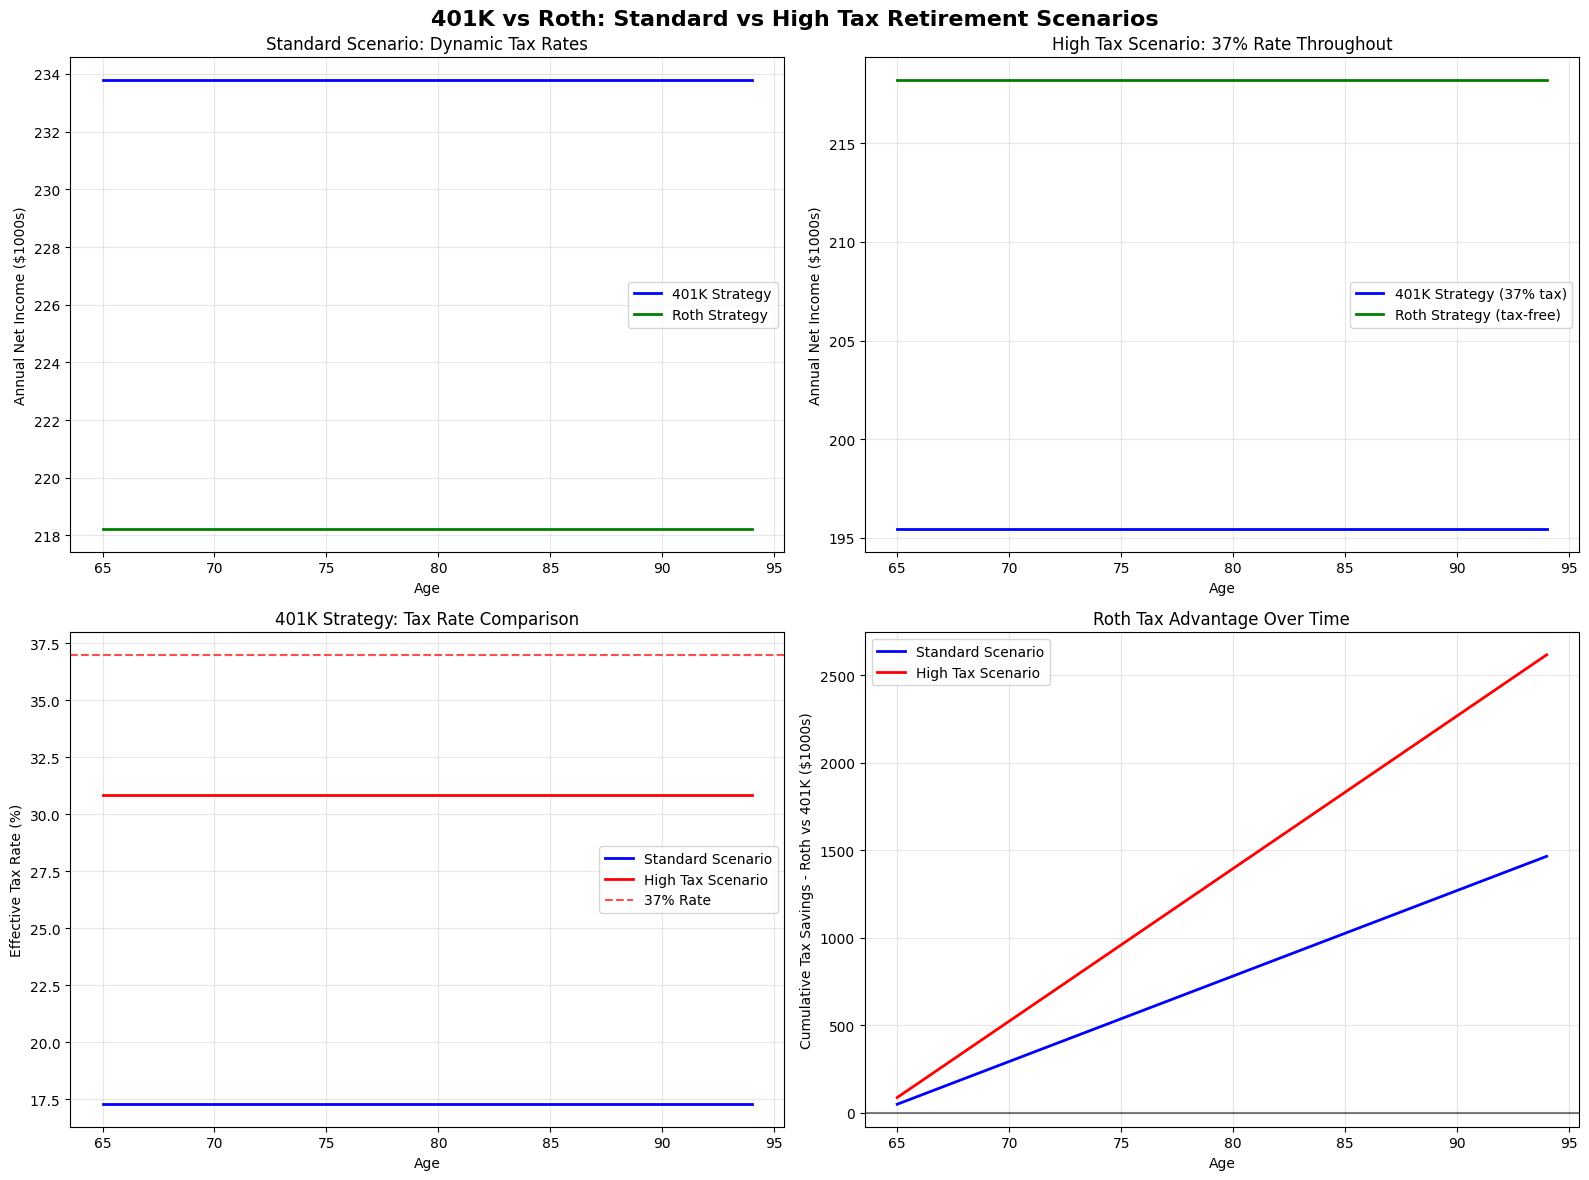

In [21]:
# Create comparison visualization for both scenarios
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('401K vs Roth: Standard vs High Tax Retirement Scenarios', fontsize=16, fontweight='bold')

# Plot 1: Net Income Comparison - Standard Scenario
ax1 = axes[0, 0]
retirement_ages = distribution_results['401K']['Age']
ax1.plot(retirement_ages, distribution_results['401K']['Net_Withdrawal'] / 1000, 
         label='401K Strategy', linewidth=2, color='blue')
ax1.plot(retirement_ages, distribution_results['Roth']['Net_Withdrawal'] / 1000, 
         label='Roth Strategy', linewidth=2, color='green')
ax1.set_xlabel('Age')
ax1.set_ylabel('Annual Net Income ($1000s)')
ax1.set_title('Standard Scenario: Dynamic Tax Rates')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Net Income Comparison - High Tax Scenario
ax2 = axes[0, 1]
ax2.plot(retirement_ages, high_tax_results['401K_High_Tax']['Net_Withdrawal'] / 1000, 
         label='401K Strategy (37% tax)', linewidth=2, color='blue')
ax2.plot(retirement_ages, high_tax_results['Roth_High_Tax']['Net_Withdrawal'] / 1000, 
         label='Roth Strategy (tax-free)', linewidth=2, color='green')
ax2.set_xlabel('Age')
ax2.set_ylabel('Annual Net Income ($1000s)')
ax2.set_title('High Tax Scenario: 37% Rate Throughout')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Tax Rate Comparison
ax3 = axes[1, 0]
ax3.plot(retirement_ages, distribution_results['401K']['Effective_Tax_Rate'] * 100, 
         label='Standard Scenario', linewidth=2, color='blue')
ax3.plot(retirement_ages, high_tax_results['401K_High_Tax']['Effective_Tax_Rate'] * 100, 
         label='High Tax Scenario', linewidth=2, color='red')
ax3.axhline(y=37, color='red', linestyle='--', alpha=0.7, label='37% Rate')
ax3.set_xlabel('Age')
ax3.set_ylabel('Effective Tax Rate (%)')
ax3.set_title('401K Strategy: Tax Rate Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative Tax Savings (Roth vs 401K)
ax4 = axes[1, 1]
# Calculate cumulative tax differences
cumulative_tax_diff_standard = []
cumulative_tax_diff_high = []
cumulative_standard = 0
cumulative_high = 0

for i in range(len(retirement_ages)):
    # Standard scenario: Roth saves taxes compared to 401K
    tax_diff_standard = distribution_results['401K']['Taxes_Paid'].iloc[i] - distribution_results['Roth']['Taxes_Paid'].iloc[i]
    cumulative_standard += tax_diff_standard
    cumulative_tax_diff_standard.append(cumulative_standard)
    
    # High tax scenario: Even more tax savings with Roth
    tax_diff_high = high_tax_results['401K_High_Tax']['Taxes_Paid'].iloc[i] - high_tax_results['Roth_High_Tax']['Taxes_Paid'].iloc[i]
    cumulative_high += tax_diff_high
    cumulative_tax_diff_high.append(cumulative_high)

ax4.plot(retirement_ages, np.array(cumulative_tax_diff_standard) / 1000, 
         label='Standard Scenario', linewidth=2, color='blue')
ax4.plot(retirement_ages, np.array(cumulative_tax_diff_high) / 1000, 
         label='High Tax Scenario', linewidth=2, color='red')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('Age')
ax4.set_ylabel('Cumulative Tax Savings - Roth vs 401K ($1000s)')
ax4.set_title('Roth Tax Advantage Over Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# Comprehensive scenario comparison summary
def create_scenario_comparison():
    """Create a comprehensive comparison table of both scenarios."""
    
    # Standard scenario totals (already calculated)
    std_401k_net = summary_stats['net_income_401k'] 
    std_roth_net = summary_stats['net_income_roth']
    std_401k_taxes = summary_stats['total_taxes_401k']
    std_roth_taxes = summary_stats['total_taxes_roth']
    
    # High tax scenario totals
    high_401k_net = total_net_income_401k_high
    high_roth_net = total_net_income_roth_high
    high_401k_taxes = total_taxes_401k_high
    high_roth_taxes = total_taxes_roth_high
    
    comparison_data = {
        'Scenario': ['Standard (Dynamic Tax)', 'High Tax (37% Rate)'],
        '401K_Net_Income': [std_401k_net, high_401k_net],
        'Roth_Net_Income': [std_roth_net, high_roth_net],
        '401K_Total_Taxes': [std_401k_taxes, high_401k_taxes],
        'Roth_Total_Taxes': [std_roth_taxes, high_roth_taxes],
        'Roth_Advantage': [std_roth_net - std_401k_net, high_roth_net - high_401k_net],
        'Roth_Advantage_Pct': [(std_roth_net / std_401k_net - 1) * 100, (high_roth_net / high_401k_net - 1) * 100]
    }
    
    return pd.DataFrame(comparison_data)

scenario_comparison = create_scenario_comparison()

print("="*80)
print("COMPREHENSIVE SCENARIO COMPARISON")
print("="*80)

print("\nSCENARIO RESULTS SUMMARY:")
print(f"{'Metric':<30} {'Standard':<15} {'High Tax':<15} {'Difference':<15}")
print("-" * 75)

# Format the comparison nicely
for _, row in scenario_comparison.iterrows():
    scenario = row['Scenario']
    print(f"\n{scenario.upper()}:")
    print(f"  401K Net Income:          ${row['401K_Net_Income']:>12,.0f}")
    print(f"  Roth Net Income:          ${row['Roth_Net_Income']:>12,.0f}")
    print(f"  401K Total Taxes:         ${row['401K_Total_Taxes']:>12,.0f}")
    print(f"  Roth Total Taxes:         ${row['Roth_Total_Taxes']:>12,.0f}")
    print(f"  Roth Advantage:           ${row['Roth_Advantage']:>12,.0f}")
    print(f"  Roth Advantage %:         {row['Roth_Advantage_Pct']:>12.1f}%")

print("\nKEY INSIGHTS:")
std_advantage = scenario_comparison.iloc[0]['Roth_Advantage']
high_advantage = scenario_comparison.iloc[1]['Roth_Advantage']
advantage_difference = high_advantage - std_advantage

if std_advantage > 0:
    std_winner = "Roth"
else:
    std_winner = "401K"
    std_advantage = abs(std_advantage)

if high_advantage > 0:
    high_winner = "Roth"
else:
    high_winner = "401K"  
    high_advantage = abs(high_advantage)

print("\n1. STANDARD SCENARIO (Dynamic Tax Rates):")
print(f"   Winner: {std_winner}")
print(f"   Advantage: ${std_advantage:,.0f} ({abs(scenario_comparison.iloc[0]['Roth_Advantage_Pct']):.1f}%)")

print("\n2. HIGH TAX SCENARIO (37% Throughout Retirement):")
print(f"   Winner: {high_winner}")
print(f"   Advantage: ${high_advantage:,.0f} ({abs(scenario_comparison.iloc[1]['Roth_Advantage_Pct']):.1f}%)")

print("\n3. SCENARIO IMPACT:")
print("   Moving to high tax retirement increases Roth advantage by:")
print(f"   ${advantage_difference:,.0f} ({advantage_difference/1000000:.1f} million)")

print("\n4. CONCLUSION:")
if high_winner == "Roth" and std_winner == "401K":
    print("   Tax rates in retirement are CRITICAL to the decision.")
    print("   If you expect to remain in high tax brackets during retirement,")
    print("   Roth becomes significantly more attractive.")
elif high_winner == "Roth" and std_winner == "Roth":
    print("   Roth is superior in BOTH scenarios, but the advantage")
    print("   increases dramatically with higher retirement tax rates.")
else:
    print("   The analysis shows varying results based on retirement tax assumptions.")

print("="*80)


COMPREHENSIVE SCENARIO COMPARISON

SCENARIO RESULTS SUMMARY:
Metric                         Standard        High Tax        Difference     
---------------------------------------------------------------------------

STANDARD (DYNAMIC TAX):
  401K Net Income:          $   7,013,946
  Roth Net Income:          $   6,546,368
  401K Total Taxes:         $   1,464,677
  Roth Total Taxes:         $           0
  Roth Advantage:           $    -467,578
  Roth Advantage %:                 -6.7%

HIGH TAX (37% RATE):
  401K Net Income:          $   5,863,241
  Roth Net Income:          $   6,546,368
  401K Total Taxes:         $   2,615,382
  Roth Total Taxes:         $           0
  Roth Advantage:           $     683,127
  Roth Advantage %:                 11.7%

KEY INSIGHTS:

1. STANDARD SCENARIO (Dynamic Tax Rates):
   Winner: 401K
   Advantage: $467,578 (6.7%)

2. HIGH TAX SCENARIO (37% Throughout Retirement):
   Winner: Roth
   Advantage: $683,127 (11.7%)

3. SCENARIO IMPACT:
   Moving 

## Key Insights and Methodology Notes

### Analysis Methodology
This analysis implements several key methodological choices that distinguish it from simplified analyses:

1. **Dynamic Tax Calculations**: Rather than assuming tax rates, we calculate actual taxes based on withdrawal amounts using progressive tax brackets.

2. **Mixed Account Structure**: The 401K strategy creates both pre-tax retirement accounts AND taxable investment accounts (from tax savings), providing more diversification.

3. **Equal Contribution Comparison**: Both strategies contribute the same dollar amount to retirement accounts, making this a fair comparison.

4. **Complete Lifecycle Modeling**: Full 60-year analysis from age 35 to 95, including both accumulation and distribution phases.

5. **Multiple Scenarios**: Analysis includes both standard (dynamic tax rates) and high tax bracket retirement scenarios.

6. **Realistic Investment Returns**: Different return assumptions for accumulation (7%) vs retirement (5%) phases.

### Critical Finding: Tax Rate Impact

The analysis reveals that **retirement tax rates are the decisive factor** in choosing between 401K and Roth strategies:

**Standard Scenario (Dynamic Tax Rates)**: Taxes calculated based on actual withdrawal amounts
**High Tax Scenario (37% Rate)**: Assumes retiree remains in highest bracket due to other income sources

### Important Considerations

- **Tax Law Changes**: This analysis uses current tax brackets which may change over 60 years
- **State Taxes**: Analysis focuses on federal taxes only
- **Investment Risk**: Assumes consistent returns without market volatility
- **Inflation**: Contribution limits grow with assumed inflation, but spending needs are not explicitly modeled
- **Estate Planning**: Analysis assumes complete depletion by age 95
- **Other Income Sources**: High tax scenario models wealthy retirees with continued substantial income

### Decision Framework

**Choose 401K (Pre-tax) When:**
- You expect significantly lower tax rates in retirement
- You have limited other retirement income sources
- You want to maximize current tax savings and investment of those savings
- You're comfortable with complex withdrawal planning

**Choose Roth When:**
- You expect to remain in high tax brackets during retirement
- You have other substantial income sources in retirement (business, rental income, pensions)
- You want tax-free growth and simplified retirement planning
- You're concerned about future tax rate increases
- Estate planning is important (tax-free inheritance)

**The Bottom Line**: For high-income earners who will likely maintain substantial income in retirement, Roth becomes significantly more attractive as retirement tax rates increase.